In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Load the dataset
data_train = pd.read_csv("train_data.csv")
data_test = pd.read_csv("test_data.csv")

In [3]:
import json
def read_index_from_json(name, file_path='FeatureSelection.json'):
    try:
        # Read the JSON data from the file
        with open(file_path, 'r') as file:
            json_data = json.load(file)
        
        # Retrieve the index list for the given name
        index_list = json_data.get(name)
        
        # Check if the name exists in the JSON data
        if index_list is None:
            raise ValueError(f"The name '{name}' does not exist in the JSON file.")
        
        # Convert the list back to a pandas Index object
        index = pd.Index(index_list)
        
        return index
    except FileNotFoundError:
        raise FileNotFoundError(f"The file '{file_path}' does not exist.")
    except json.JSONDecodeError:
        raise ValueError(f"The file '{file_path}' does not contain valid JSON.")

In [4]:
top_features = read_index_from_json("MI")
X_train = data_train.drop(columns=["Revenue_int"])
X_train = X_train.loc[:,top_features]
y_train = data_train["Revenue_int"]
X_test = data_test.drop(columns=["Revenue_int"])
X_test = X_test.loc[:,top_features]
y_test = data_test["Revenue_int"]

In [5]:
# Initialize and train the logistic regression model using features from MI
logreg = LogisticRegression(max_iter=1000, solver='newton-cg')
logreg.fit(X_train, y_train)

# Prediction: get the probability of the positive class
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  # Only positive class probabilities
y_pred = logreg.predict(X_test)


# Calculate accuracy and display classification report
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Compute AUC
auc_score = roc_auc_score(y_test, y_pred_proba)

d:\Softwares\Minoconda\envs\FPA_DA\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
d:\Softwares\Minoconda\envs\FPA_DA\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


In [6]:
# Display results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", confusion_mat)
print(f"AUC Score: {auc_score}")


Accuracy: 0.8475358096625395
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86      2038
           1       0.90      0.79      0.84      2081

    accuracy                           0.85      4119
   macro avg       0.85      0.85      0.85      4119
weighted avg       0.85      0.85      0.85      4119

Confusion Matrix:
 [[1854  184]
 [ 444 1637]]
AUC Score: 0.9116036064415697


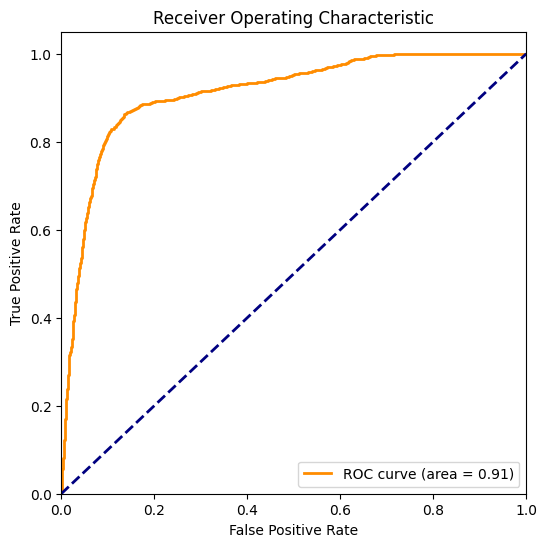

<Figure size 600x600 with 0 Axes>

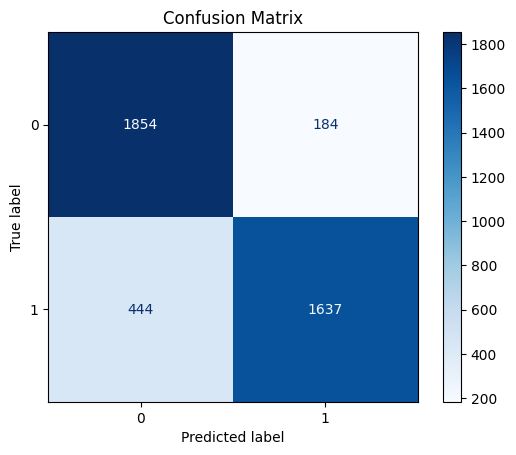

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 3. Confusion Matrix Visualization
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [14]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from scipy.stats import uniform, randint

# Define the parameter distribution
param_dist = {
    'C': uniform(0.1, 10),  # Inverse of regularization strength; must be a positive float.
    'penalty': ['l2'],  # Regularization type.
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithm to use in the optimization problem.
    'max_iter': randint(100, 1000)  # Maximum number of iterations.
}

# Initialize the LogisticRegression model
logreg = LogisticRegression(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=logreg, param_distributions=param_dist, 
                                   n_iter=50, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc', random_state=42)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = random_search.best_params_
best_logreg = random_search.best_estimator_
print("Best parameters found: ", best_params)

# Evaluate the best model on the test data
y_pred_proba = best_logreg.predict_proba(X_test)[:, 1]  # Only positive class probabilities
y_pred = best_logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")
print(f"Confusion Matrix:\n{confusion_mat}")
print(f"AUC Score: {auc_score}")

# Store all iterations' scores and parameters in a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

# Select relevant columns
results_df = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

# Display the top rows of the DataFrame
print(results_df.head())

# Save the DataFrame to a CSV file
results_df.to_csv('logreg_random_search_results.csv', index=False)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.
